<a href="https://colab.research.google.com/github/pavananna/Project-6/blob/main/Project_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import prophet
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression,LogisticRegressionCV,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [17]:
Train_Dataset = pd.read_csv("/train.csv")

In [ ]:
Train_Dataset.shape

(1017209, 9)

In [ ]:
Train_Dataset.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
39314,290,5,2015-06-26,6500,641,1,0,0,0
925376,712,7,2013-03-24,0,0,0,0,0,0
373078,233,4,2014-08-07,8420,929,1,1,0,1
686803,749,4,2013-10-24,5226,678,1,1,0,0
555416,932,3,2014-02-19,7767,783,1,1,0,0


In [ ]:
Train_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
Train_Dataset['StateHoliday'].value_counts()

,count
StateHoliday,
0,855087
0,131072
a,20260
b,6690
c,4100


In [18]:
Train_Dataset['StateHoliday']=Train_Dataset['StateHoliday'].map({0:'0','0':'0','a':'a','b':'b','c':'c'})

In [ ]:
Train_Dataset['StateHoliday'].value_counts()

,count
StateHoliday,
0,986159
a,20260
b,6690
c,4100


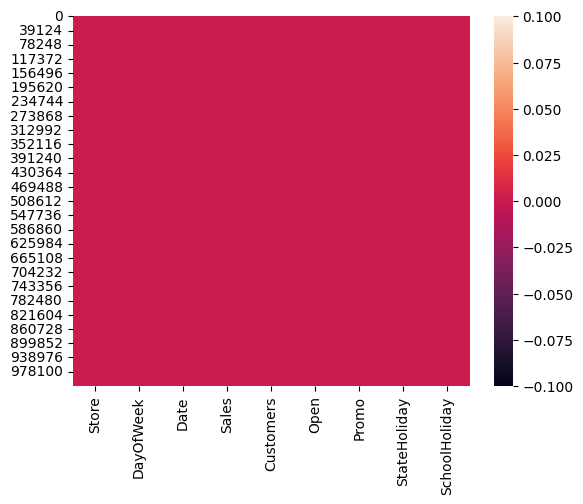

In [ ]:
sns.heatmap(Train_Dataset.isnull())
plt.show()

In [19]:
Test_Dataset = pd.read_csv("/test.csv")

In [20]:
Test_Dataset.shape

(41088, 8)

In [21]:
Test_Dataset.sample(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
37809,37810,190,2,2015-08-04,1.0,1,0,1
17270,17271,195,5,2015-08-28,1.0,0,0,0
9985,9986,736,7,2015-09-06,0.0,0,0,0
34951,34952,920,6,2015-08-08,1.0,0,0,0
23929,23930,1065,5,2015-08-21,1.0,1,0,1


In [ ]:
Test_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [ ]:
Test_Dataset.isnull().mean()*100

,0
Id,0.000000
Store,0.000000
DayOfWeek,0.000000
Date,0.000000
Open,0.026772
Promo,0.000000
StateHoliday,0.000000
SchoolHoliday,0.000000


In [ ]:
Test_Dataset[Test_Dataset['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [ ]:
Test_Dataset.select_dtypes(include=['number']).corr()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
Id,1.000000,2.083250e-02,5.483047e-02,-0.049313,-1.690971e-02,0.387661
Store,0.020833,1.000000e+00,-5.032372e-17,0.000818,-3.682700e-16,-0.011757
DayOfWeek,0.054830,-5.032372e-17,1.000000e+00,-0.610797,-4.355177e-01,-0.352948
Open,-0.049313,8.182058e-04,-6.107974e-01,1.000000,3.325565e-01,0.278293
Promo,-0.016910,-3.682700e-16,-4.355177e-01,0.332556,1.000000e+00,0.219202
SchoolHoliday,0.387661,-1.175748e-02,-3.529484e-01,0.278293,2.192020e-01,1.000000


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 4) & (Train_Dataset['Promo'] == 1) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
17346,622,4,2015-07-16,5615,494,1,1,0,0
32956,622,4,2015-07-02,5732,521,1,1,0,0
48566,622,4,2015-06-18,4619,426,1,1,0,0
64176,622,4,2015-06-04,4836,453,1,1,0,0
79786,622,4,2015-05-21,4542,434,1,1,0,0
95396,622,4,2015-05-07,5120,489,1,1,0,0
103201,622,4,2015-04-30,6667,553,1,1,0,0
150031,622,4,2015-03-19,4133,455,1,1,0,0
165641,622,4,2015-03-05,5151,487,1,1,0,0
181251,622,4,2015-02-19,4389,452,1,1,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 3) & (Train_Dataset['Promo'] == 1) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
18461,622,3,2015-07-15,4718,434,1,1,0,0
34071,622,3,2015-07-01,5915,525,1,1,0,0
49681,622,3,2015-06-17,5107,437,1,1,0,0
65291,622,3,2015-06-03,5399,469,1,1,0,0
80901,622,3,2015-05-20,4745,427,1,1,0,0
96511,622,3,2015-05-06,5007,476,1,1,0,0
104316,622,3,2015-04-29,5408,503,1,1,0,0
151146,622,3,2015-03-18,4599,432,1,1,0,0
166756,622,3,2015-03-04,4033,390,1,1,0,0
182366,622,3,2015-02-18,4426,403,1,1,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 2) & (Train_Dataset['Promo'] == 1) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
19576,622,2,2015-07-14,5102,439,1,1,0,0
35186,622,2,2015-06-30,6162,512,1,1,0,0
50796,622,2,2015-06-16,4874,448,1,1,0,0
66406,622,2,2015-06-02,5389,470,1,1,0,0
82016,622,2,2015-05-19,4667,444,1,1,0,0
97626,622,2,2015-05-05,4174,420,1,1,0,0
105431,622,2,2015-04-28,4675,432,1,1,0,0
136651,622,2,2015-03-31,5454,445,1,1,0,0
152261,622,2,2015-03-17,5379,461,1,1,0,0
167871,622,2,2015-03-03,5261,478,1,1,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 1) & (Train_Dataset['Promo'] == 1) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
20691,622,1,2015-07-13,6349,535,1,1,0,0
36301,622,1,2015-06-29,6078,504,1,1,0,0
51911,622,1,2015-06-15,5518,526,1,1,0,0
67521,622,1,2015-06-01,6081,528,1,1,0,0
83131,622,1,2015-05-18,5302,512,1,1,0,0
98741,622,1,2015-05-04,6154,563,1,1,0,0
106546,622,1,2015-04-27,6055,541,1,1,0,0
137766,622,1,2015-03-30,7043,549,1,1,0,0
153376,622,1,2015-03-16,6540,530,1,1,0,0
168986,622,1,2015-03-02,5990,541,1,1,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 6) & (Train_Dataset['Promo'] == 0) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
7311,622,6,2015-07-25,2644,257,1,0,0,0
15116,622,6,2015-07-18,2367,265,1,0,0,0
22921,622,6,2015-07-11,2511,281,1,0,0,0
30726,622,6,2015-07-04,3221,319,1,0,0,0
38531,622,6,2015-06-27,2751,280,1,0,0,0
...,...,...,...,...,...,...,...,...,...
981036,622,6,2013-02-02,2985,298,1,0,0,0
988841,622,6,2013-01-26,2121,226,1,0,0,0
996646,622,6,2013-01-19,2352,256,1,0,0,0
1004451,622,6,2013-01-12,2131,245,1,0,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 5) & (Train_Dataset['Promo'] == 0) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
24036,622,5,2015-07-10,4493,478,1,0,0,0
39646,622,5,2015-06-26,4035,422,1,0,0,0
55256,622,5,2015-06-12,4522,465,1,0,0,0
70866,622,5,2015-05-29,5424,492,1,0,0,0
109891,622,5,2015-04-24,3542,408,1,0,0,0
141111,622,5,2015-03-27,3998,407,1,0,0,0
156721,622,5,2015-03-13,4533,463,1,0,0,0
172331,622,5,2015-02-27,4773,483,1,0,0,0
187941,622,5,2015-02-13,4488,455,1,0,0,0
211356,622,5,2015-01-23,4386,446,1,0,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 4) & (Train_Dataset['Promo'] == 0) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
25151,622,4,2015-07-09,4788,477,1,0,0,0
40761,622,4,2015-06-25,3609,384,1,0,0,0
56371,622,4,2015-06-11,3952,401,1,0,0,0
71981,622,4,2015-05-28,4051,400,1,0,0,0
111006,622,4,2015-04-23,3482,383,1,0,0,0
142226,622,4,2015-03-26,3855,405,1,0,0,0
157836,622,4,2015-03-12,3782,448,1,0,0,0
173446,622,4,2015-02-26,3648,393,1,0,0,0
189056,622,4,2015-02-12,3517,421,1,0,0,0
212471,622,4,2015-01-22,3584,385,1,0,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 3) & (Train_Dataset['Promo'] == 0) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
26266,622,3,2015-07-08,4042,406,1,0,0,0
41876,622,3,2015-06-24,4030,388,1,0,0,0
57486,622,3,2015-06-10,4039,448,1,0,0,0
73096,622,3,2015-05-27,4037,394,1,0,0,0
88706,622,3,2015-05-13,5156,529,1,0,0,0
112121,622,3,2015-04-22,3052,340,1,0,0,0
143341,622,3,2015-03-25,3490,380,1,0,0,0
158951,622,3,2015-03-11,3572,396,1,0,0,0
174561,622,3,2015-02-25,3580,379,1,0,0,0
190171,622,3,2015-02-11,3699,442,1,0,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 2) & (Train_Dataset['Promo'] == 0) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
27381,622,2,2015-07-07,3642,405,1,0,0,0
42991,622,2,2015-06-23,3843,418,1,0,0,0
58601,622,2,2015-06-09,3532,381,1,0,0,0
74211,622,2,2015-05-26,4250,451,1,0,0,0
89821,622,2,2015-05-12,3929,440,1,0,0,0
113236,622,2,2015-04-21,3703,377,1,0,0,0
144456,622,2,2015-03-24,3825,399,1,0,0,0
160066,622,2,2015-03-10,3347,383,1,0,0,0
175676,622,2,2015-02-24,3329,354,1,0,0,0
191286,622,2,2015-02-10,3643,399,1,0,0,0


In [ ]:
Train_Dataset[(Train_Dataset['Store'] == 622) & (Train_Dataset['DayOfWeek'] == 1) & (Train_Dataset['Promo'] == 0) & (Train_Dataset['StateHoliday'] == '0') & (Train_Dataset['SchoolHoliday'] == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
28496,622,1,2015-07-06,4516,453,1,0,0,0
44106,622,1,2015-06-22,4334,452,1,0,0,0
59716,622,1,2015-06-08,3739,398,1,0,0,0
90936,622,1,2015-05-11,3893,430,1,0,0,0
114351,622,1,2015-04-20,4299,464,1,0,0,0
145571,622,1,2015-03-23,3723,417,1,0,0,0
161181,622,1,2015-03-09,4240,469,1,0,0,0
176791,622,1,2015-02-23,4363,482,1,0,0,0
192401,622,1,2015-02-09,3793,439,1,0,0,0
215816,622,1,2015-01-19,4116,435,1,0,0,0


If You See all The Codes For All Of them The Value Of Open is "1" So we can fill it with 1.

In [22]:
Test_Dataset['Open'].fillna(0,inplace=True)

In [23]:
Test_Dataset.isnull().mean()*100

,0
Id,0.0
Store,0.0
DayOfWeek,0.0
Date,0.0
Open,0.0
Promo,0.0
StateHoliday,0.0
SchoolHoliday,0.0


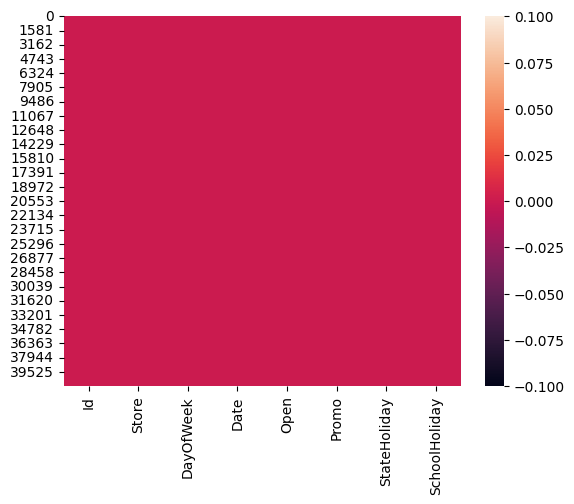

In [ ]:
sns.heatmap(Test_Dataset.isnull())
plt.show()

In [ ]:
Test_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41088 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [24]:
Store_Dataset = pd.read_csv("/store.csv")

In [ ]:
Store_Dataset.shape

(1115, 10)

In [ ]:
Store_Dataset.sample(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
44,45,d,a,9710.0,2.0,2014.0,0,NaN,NaN,NaN
602,603,a,a,340.0,4.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
778,779,a,a,16990.0,4.0,2004.0,0,NaN,NaN,NaN
205,206,a,c,380.0,NaN,NaN,1,14.0,2012.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN


In [ ]:
Store_Dataset.isnull().mean()*100

,0
Store,0.000000
StoreType,0.000000
Assortment,0.000000
CompetitionDistance,0.269058
CompetitionOpenSinceMonth,31.748879
CompetitionOpenSinceYear,31.748879
Promo2,0.000000
Promo2SinceWeek,48.789238
Promo2SinceYear,48.789238
PromoInterval,48.789238


In [ ]:
# Calculate correlation for numeric columns only
Store_Dataset.select_dtypes(include=['number']).corr()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Store,1.000000,-0.027220,-0.050319,-0.004648,0.007486,0.007584,0.039640
CompetitionDistance,-0.027220,1.000000,-0.059126,0.025124,-0.145717,-0.060552,-0.109504
CompetitionOpenSinceMonth,-0.050319,-0.059126,1.000000,-0.052250,-0.011485,-0.035504,0.047815
CompetitionOpenSinceYear,-0.004648,0.025124,-0.052250,1.000000,-0.076520,-0.079984,0.006354
Promo2,0.007486,-0.145717,-0.011485,-0.076520,1.000000,NaN,NaN
Promo2SinceWeek,0.007584,-0.060552,-0.035504,-0.079984,NaN,1.000000,-0.217650
Promo2SinceYear,0.039640,-0.109504,0.047815,0.006354,NaN,-0.217650,1.000000


In [ ]:
Store_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


**Handling Missing Values**

In [25]:
Store_Dataset['Promo2SinceWeek'] = Store_Dataset['Promo2SinceWeek'].fillna(0)
Store_Dataset['Promo2SinceYear'] = Store_Dataset['Promo2SinceYear'].fillna(0)
Store_Dataset['PromoInterval'] = Store_Dataset['PromoInterval'].fillna("No_promotion")

In [26]:
Store_Dataset['CompetitionDistance'] = Store_Dataset['CompetitionDistance'].fillna(Store_Dataset['CompetitionDistance'].mean())
Store_Dataset['CompetitionOpenSinceMonth'] = Store_Dataset['CompetitionOpenSinceMonth'].fillna(Store_Dataset['CompetitionOpenSinceMonth'].mean())
Store_Dataset['CompetitionOpenSinceYear'] = Store_Dataset['CompetitionOpenSinceYear'].fillna(Store_Dataset['CompetitionOpenSinceYear'].mean())

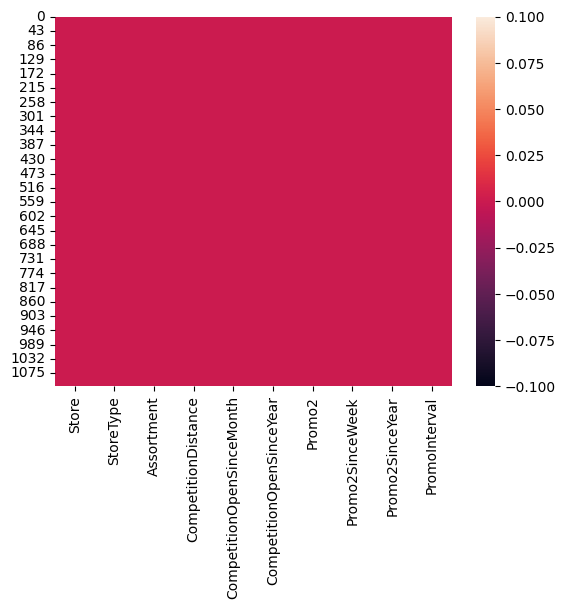

In [ ]:
sns.heatmap(Store_Dataset.isnull())
plt.show()

**Handling Outliers**

In [ ]:
Train_Dataset.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [27]:
Outliers_train_columns = ['Sales','Customers']

In [28]:
for i in Outliers_train_columns:
  q3 = Train_Dataset[i].quantile(0.75)
  q1 = Train_Dataset[i].quantile(0.25)
  IQR = q3 - q1
  upper = q3 + 1.5 * IQR
  lower = q1 - 1.5 * IQR

  Train_Dataset[i] = np.where(Train_Dataset[i] > upper, upper, Train_Dataset[i])
  Train_Dataset[i] = np.where(Train_Dataset[i] < lower, lower, Train_Dataset[i])


<Axes: >

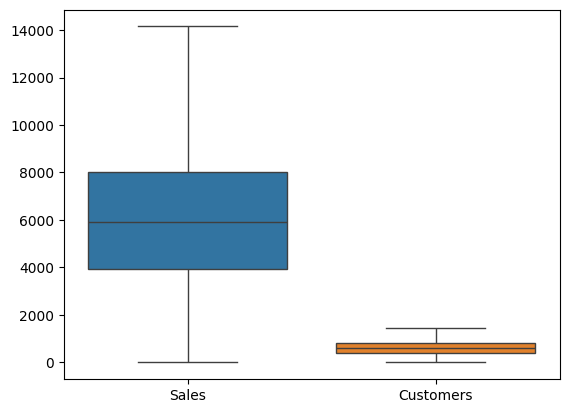

In [29]:
sns.boxplot(Train_Dataset[['Sales','Customers']])

In [ ]:
Test_Dataset.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854094,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.353017,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [ ]:
Store_Dataset.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,12.083408,1030.239462
std,322.01708,7652.849306,2.653302,5.117695,0.500078,15.542241,1006.038782
min,1.00000,20.000000,1.000000,1900.000000,0.000000,0.000000,0.000000
25%,279.50000,720.000000,6.000000,2008.000000,0.000000,0.000000,0.000000
50%,558.00000,2330.000000,7.224704,2008.668857,1.000000,1.000000,2009.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [30]:
q3 = Store_Dataset['CompetitionDistance'].quantile(0.75)
q1 = Store_Dataset['CompetitionDistance'].quantile(0.25)
IQR = q3 - q1

upper = q3 + 1.5 * IQR
lower = q1 - 1.5 * IQR

Store_Dataset['CompetitionDistance'] = np.where(Store_Dataset['CompetitionDistance'] > upper, upper, Store_Dataset['CompetitionDistance'])
Store_Dataset['CompetitionDistance'] = np.where(Store_Dataset['CompetitionDistance'] < lower, lower, Store_Dataset['CompetitionDistance'])

<Axes: ylabel='CompetitionDistance'>

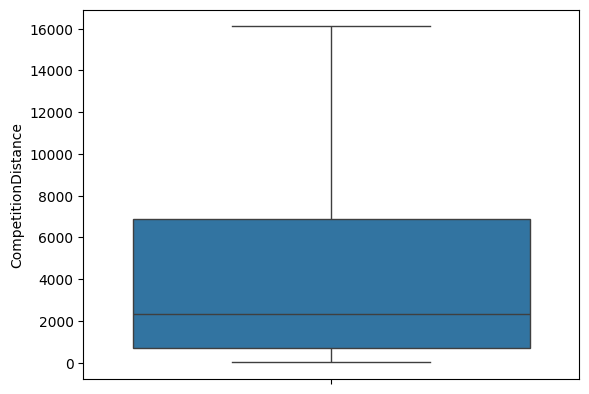

In [ ]:
sns.boxplot(Store_Dataset['CompetitionDistance'])

**Visualization**

In [ ]:
Train_Dataset['Date'] = pd.to_datetime(Train_Dataset['Date'])

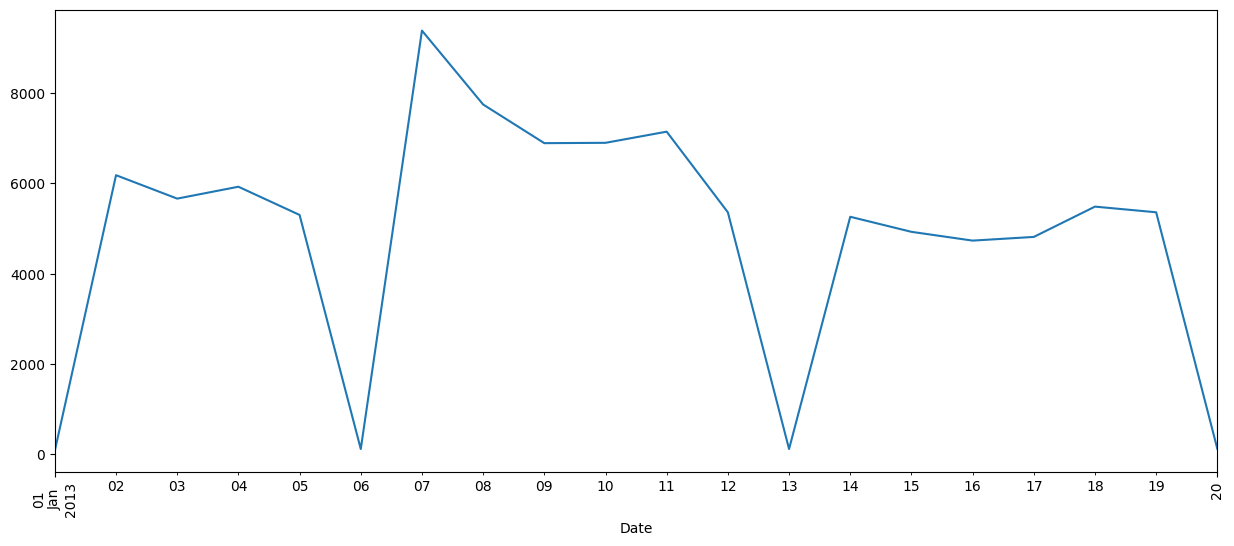

In [ ]:
Train_Dataset.groupby('Date')['Sales'].mean().head(20).plot(figsize=(15, 6))
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.show()

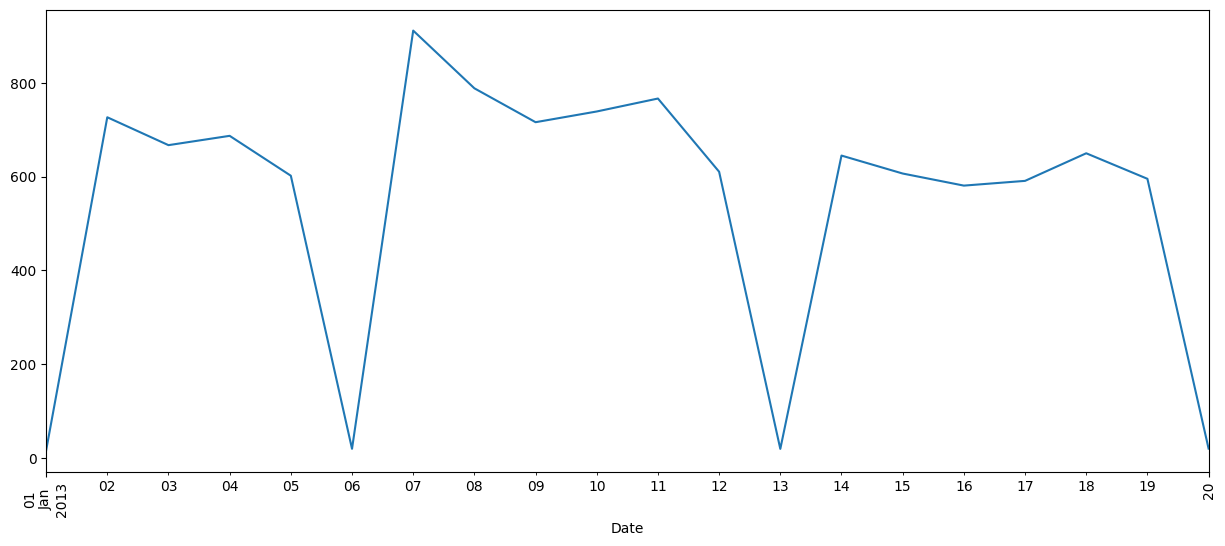

In [ ]:
Train_Dataset.groupby('Date')['Customers'].mean().head(20).plot(figsize=(15, 6))
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.show()

In [31]:
Train_Predict_Columns = Train_Dataset[['Date','Sales']]

In [ ]:
m = prophet.Prophet()
Train_Predict_Columns.columns = ['ds','y']
model = m.fit(Train_Predict_Columns)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpethgc_qg/1bg0cmi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpethgc_qg/k6dnlwie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45149', 'data', 'file=/tmp/tmpethgc_qg/1bg0cmi1.json', 'init=/tmp/tmpethgc_qg/k6dnlwie.json', 'output', 'file=/tmp/tmpethgc_qg/prophet_modelgv6befax/prophet_model-20250102095338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:53:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Perdiction For Next Six Months**

In [ ]:
future = m.make_future_dataframe(periods=200,freq='D')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1137,2016-02-12,6151.566948,3586.003172,10447.935383,5446.444717,6754.908004,817.039567,817.039567,817.039567,963.335497,963.335497,963.335497,-146.295930,-146.295930,-146.295930,0.0,0.0,0.0,6968.606515
1138,2016-02-13,6152.394340,2481.044181,9508.814317,5441.486480,6761.042528,-44.594908,-44.594908,-44.594908,107.570846,107.570846,107.570846,-152.165754,-152.165754,-152.165754,0.0,0.0,0.0,6107.799432
1139,2016-02-14,6153.221732,-3007.418553,3855.022487,5438.118892,6767.115603,-5660.674617,-5660.674617,-5660.674617,-5504.949039,-5504.949039,-5504.949039,-155.725578,-155.725578,-155.725578,0.0,0.0,0.0,492.547115
1140,2016-02-15,6154.049123,4356.581705,11418.726045,5435.245632,6772.691023,1752.141629,1752.141629,1752.141629,1909.258323,1909.258323,1909.258323,-157.116694,-157.116694,-157.116694,0.0,0.0,0.0,7906.190752
1141,2016-02-16,6154.876515,3617.563862,10755.992539,5431.205740,6778.266442,1065.837429,1065.837429,1065.837429,1222.371783,1222.371783,1222.371783,-156.534354,-156.534354,-156.534354,0.0,0.0,0.0,7220.713943


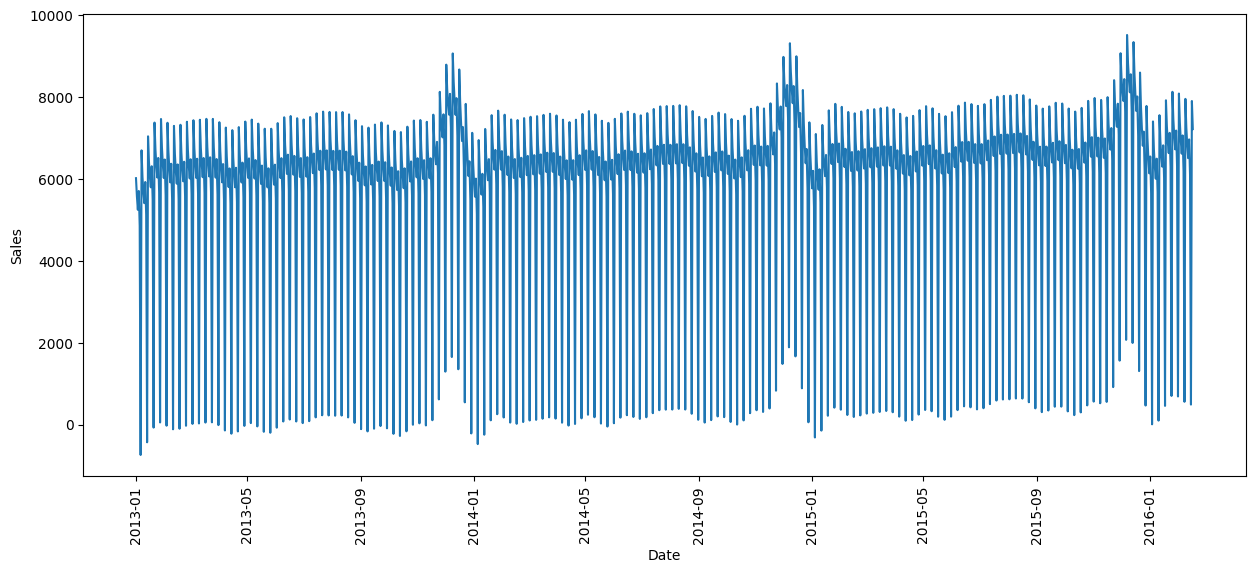

In [ ]:
plt.figure(figsize=(15,6))
plt.plot('ds','yhat',data=forecast)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
from prophet.plot import plot_plotly,plot_components_plotly


In [ ]:
#plot_plotly(m,forecast)

In [ ]:
plot_components_plotly(m,forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



**Adding Additional Features**

In [32]:
#Converting Date Datatype
Train_Dataset['Date'] = pd.to_datetime(Train_Dataset['Date'])

#Now extracing Day Name
Train_Dataset['Day_Name'] = Train_Dataset['Date'].dt.day_name()

In [33]:
Train_Dataset['Weekends'] = np.where(Train_Dataset['Day_Name'].isin(['Saturday','Sunday']),1,0)

In [ ]:
Train_Dataset.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day_Name,Weekends
49718,659,3,2015-06-17,6183.0,745.0,1,1,0,0,Wednesday,0
262517,1064,4,2014-12-04,11036.0,1148.0,1,1,0,0,Thursday,0
147533,354,6,2015-03-21,8504.0,778.0,1,0,0,0,Saturday,1
159811,367,2,2015-03-10,3993.0,472.0,1,0,0,0,Tuesday,0
38850,941,6,2015-06-27,4535.0,482.0,1,0,0,0,Saturday,1
779281,682,5,2013-08-02,12925.0,1485.0,1,1,0,1,Friday,0
361759,106,2,2014-08-19,8510.0,834.0,1,1,0,1,Tuesday,0
487006,537,1,2014-04-21,0.0,0.0,0,0,b,1,Monday,0
845739,240,1,2013-06-03,5748.0,544.0,1,1,0,0,Monday,0
489174,475,6,2014-04-19,7493.0,1246.0,1,0,0,0,Saturday,1


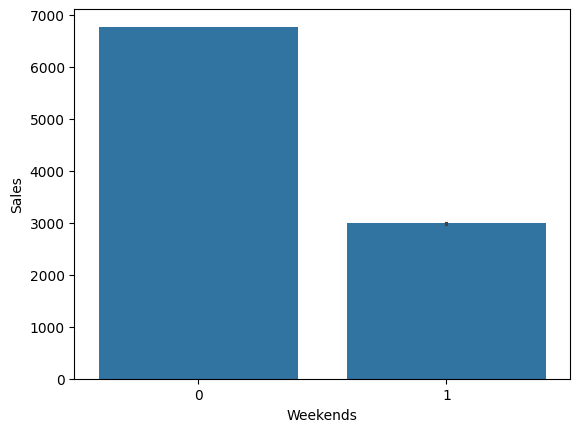

In [ ]:
sns.barplot(x='Weekends',y='Sales',data=Train_Dataset)
plt.show()

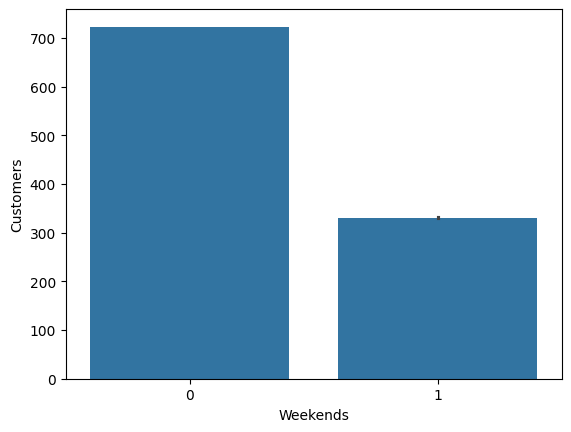

In [ ]:
sns.barplot(x="Weekends",y="Customers",data=Train_Dataset)
plt.show()

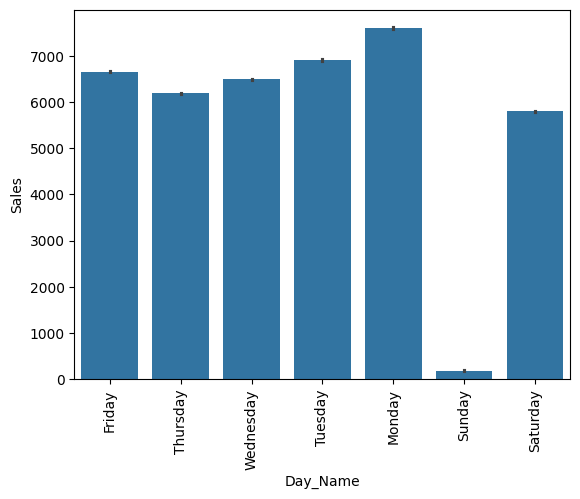

In [ ]:
sns.barplot(x="Day_Name",y="Sales",data=Train_Dataset)
plt.xticks(rotation='vertical')
plt.show()

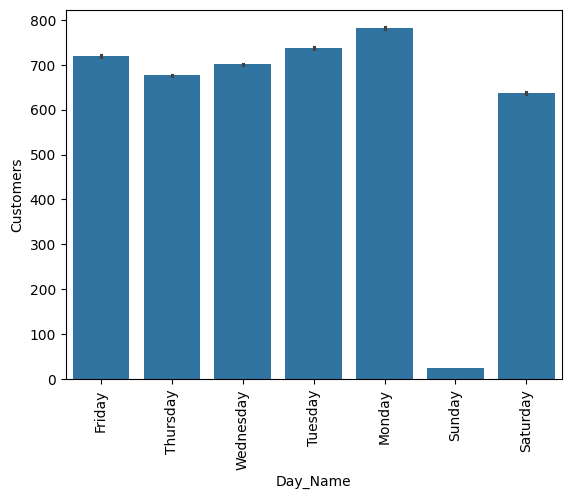

In [ ]:
sns.barplot(x="Day_Name",y="Customers",data=Train_Dataset)
plt.xticks(rotation='vertical')
plt.show()

**Analyse Questions**

**Compare the distribution of promotions across training and test sets.**

<ipython-input-65-b97072b3fd2e>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-65-b97072b3fd2e>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




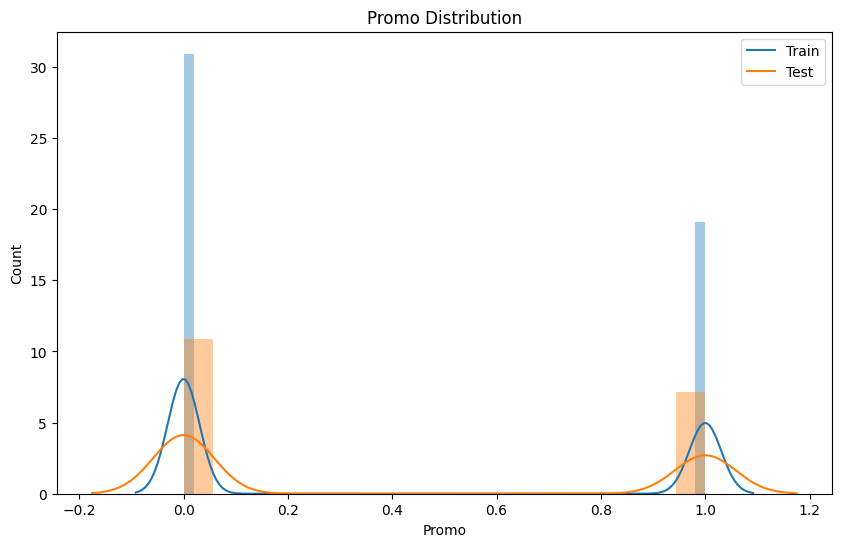

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_title('Promo Distribution')
ax1.set_xlabel('Promo')
ax1.set_ylabel('Count')
sns.distplot(Train_Dataset['Promo'],ax=ax1)
sns.distplot(Test_Dataset['Promo'],ax=ax1)

ax1.legend(['Train', 'Test'])
plt.show()


**Analyze sales trends before, during, and after holidays.**


In [ ]:
Train_Dataset.groupby('DayOfWeek')['Sales'].mean()

,Sales
DayOfWeek,
1,7599.173160
2,6907.151619
3,6490.340463
4,6185.296246
5,6651.862697
6,5794.275461
7,183.358129


In [ ]:
Train_Dataset.groupby('DayOfWeek')['Customers'].mean()

,Customers
DayOfWeek,
1,781.505148
2,736.727860
3,700.533979
4,675.857383
5,718.934430
6,636.839688
7,24.976688


In [ ]:
Train_Dataset.groupby(['DayOfWeek','StateHoliday','SchoolHoliday'])['Sales'].mean()

DayOfWeek  StateHoliday  SchoolHoliday
1          0             0                7847.572300
                         1                8415.943027
           a             0                 209.556859
                         1                   0.000000
           b             0                 167.255952
                         1                 201.774976
2          0             0                6971.513130
                         1                6983.561061
           a             0                  77.080906
                         1                  84.396320
3          0             0                6668.193725
                         1                6574.897488
           a             0                 139.754545
                         1                 100.915247
           c             1                 118.734978
4          0             0                6662.788240
                         1                6731.914490
           a             0                 450.171093
                         1                 204.712359
           c             1                 151.820000
5          0             0                7050.989149
                         1                6748.289597
           a             0                 215.111391
                         1                 136.109113
           b             0                 181.674569
                         1                 163.524093
           c             1                 191.721925
6          0             0                5808.038275
                         1                5897.980727
           a             0                 201.784461
7          0             0                 180.848077
                         1                 331.071219
           a             0                  32.213592
Name: Sales, dtype: float64

From this we can say when the When the week day is 1 and their is a School Holiday the Sales are More.

In [ ]:
Train_Dataset.groupby(['DayOfWeek','StateHoliday','SchoolHoliday'])['Customers'].mean()

DayOfWeek  StateHoliday  SchoolHoliday
1          0             0                810.434233
                         1                852.500227
           a             0                 27.222967
                         1                  0.000000
           b             0                 17.678571
                         1                 27.136760
2          0             0                744.307907
                         1                742.450128
           a             0                 13.504854
                         1                 15.038600
3          0             0                720.456488
                         1                706.717367
           a             0                 18.712253
                         1                 16.363229
           c             1                 17.306726
4          0             0                727.511090
                         1                736.224903
           a             0                 51.884666
                         1                 25.857488
           c             1                 20.484878
5          0             0                758.560117
                         1                740.421089
           a             0                 26.968894
                         1                 17.395683
           b             0                 19.202586
                         1                 21.307742
           c             1                 24.001070
6          0             0                638.546562
                         1                638.118576
           a             0                 22.330827
7          0             0                 24.660917
                         1                 43.328928
           a             0                  7.993528
Name: Customers, dtype: float64

From this we can say when the When the week day is 1 and their is a School Holiday and aslo when the weekday is 6 and their is school holiday  the Customers are More.

**Investigate seasonal purchasing patterns (e.g., Christmas, Easter).**

In [ ]:
Train_Dataset.groupby('StateHoliday')['Sales'].mean()

,Sales
StateHoliday,
0,5862.657646
a,266.167053
b,181.978700
c,151.922073


In [ ]:
Train_Dataset.groupby('StateHoliday')['Customers'].mean()

,Customers
StateHoliday,
0,629.482211
a,32.620434
b,23.792975
c,20.422439


When the State declared as holiday there will be festival or something.

In [ ]:
Train_Dataset.groupby('SchoolHoliday')['Sales'].mean()

,Sales
SchoolHoliday,
0,5542.425554
1,6373.041214


In [ ]:
Train_Dataset.groupby('SchoolHoliday')['Customers'].mean()

,Customers
SchoolHoliday,
0,596.214032
1,679.853600


**Evaluate the impact of promotions on customer behavior.**

In [ ]:
Train_Dataset.groupby('Promo')['Customers'].mean()

,Customers
Promo,
0,500.441779
1,790.638294


In [ ]:


Train_Dataset.groupby('Promo')['Sales'].mean()

,Sales
Promo,
0,4367.538696
1,7836.013738


From This We Can Say That When the Promo Code is Applied the Sales is High, and Customers visit is also high.

In [ ]:
Train_Dataset.groupby('Date')['Customers'].mean().sort_values(ascending=False).head(10)

,Customers
Date,
2013-12-23,1214.660987
2014-12-23,1123.262032
2014-12-22,1106.269519
2013-12-16,1099.498655
2014-12-15,1053.499465
2013-12-20,1018.033184
2014-06-30,1011.139013
2013-12-02,1008.173094
2013-12-17,1000.648430


In [ ]:
Train_Dataset.groupby('Date')['Sales'].mean().sort_values(ascending=False).head(10)

,Sales
Date,
2013-12-16,12105.167713
2014-12-15,11685.399465
2013-12-23,11641.280717
2014-06-30,11027.256054
2014-12-22,10931.647594
2013-12-02,10867.344843
2013-12-17,10867.313004
2014-12-23,10828.484492
2014-12-16,10672.023529


**Assess correlations between sales and customer numbers**

In [ ]:
Train_Dataset.select_dtypes(include=['number']).corr()['Sales']

,Sales
Store,0.003404
DayOfWeek,-0.481886
Sales,1.000000
Customers,0.920805
Open,0.715977
Promo,0.468557
SchoolHoliday,0.088484
Weekends,-0.473906


The Correlation between the Customers and sale is 0.886155 means highly coraltive

In [34]:
Store_train_dataset = Train_Dataset.merge(Store_Dataset, on='Store', how='left')

In [ ]:
Store_train_dataset

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day_Name,Weekends,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,Friday,0,c,a,1270.0,9.000000,2008.000000,0,0.0,0.0,No_promotion
1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,Friday,0,a,a,570.0,11.000000,2007.000000,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,Friday,0,a,a,14130.0,12.000000,2006.000000,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995.0,1485.0,1,1,0,1,Friday,0,c,c,620.0,9.000000,2009.000000,0,0.0,0.0,No_promotion
4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,Friday,0,a,a,16107.5,4.000000,2015.000000,0,0.0,0.0,No_promotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0.0,0.0,0,0,a,1,Tuesday,0,a,a,1900.0,6.000000,2014.000000,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0.0,0.0,0,0,a,1,Tuesday,0,c,c,1880.0,4.000000,2006.000000,0,0.0,0.0,No_promotion
1017206,1113,2,2013-01-01,0.0,0.0,0,0,a,1,Tuesday,0,a,c,9260.0,7.224704,2008.668857,0,0.0,0.0,No_promotion
1017207,1114,2,2013-01-01,0.0,0.0,0,0,a,1,Tuesday,0,a,c,870.0,7.224704,2008.668857,0,0.0,0.0,No_promotion


In [ ]:
Store_train_dataset.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
Day_Name,0


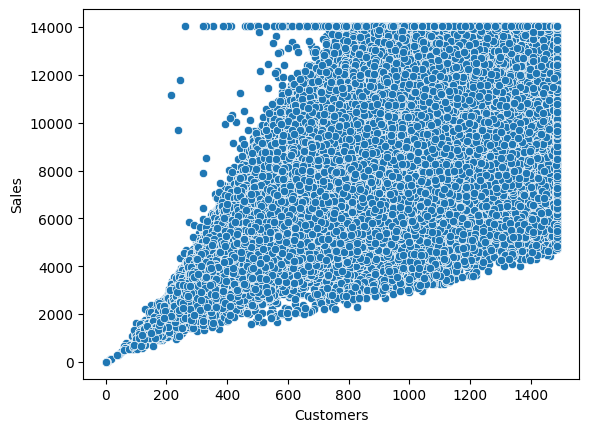

In [ ]:
# Assess correlations between sales and customer numbers.
sns.scatterplot(x='Customers', y='Sales', data=Store_train_dataset)
plt.show()

**Examine trends of sales based on store opening/closing times.**

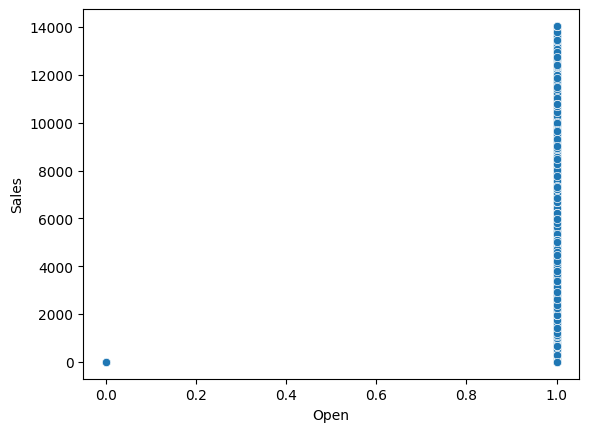

In [ ]:
sns.scatterplot(x='Open', y='Sales', data=Store_train_dataset)
plt.show()

 **Determine the effect of competitor distance on store sales**

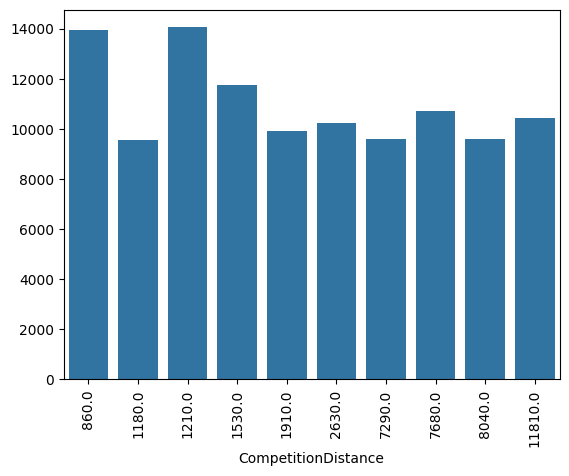

In [38]:
top_10 = Store_train_dataset.groupby('CompetitionDistance')['Sales'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_10.index, y=top_10.values)
plt.xticks(rotation='vertical')
plt.show()


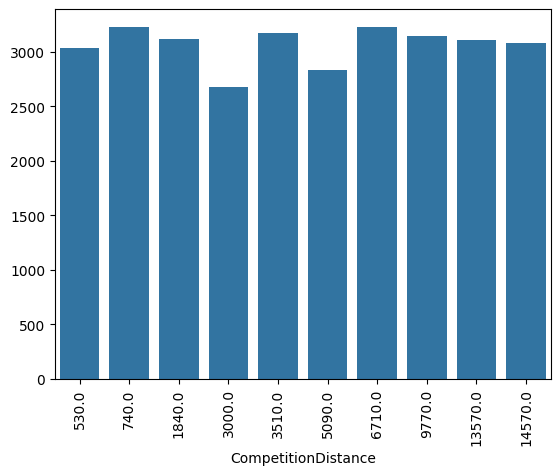

In [39]:
Bottom_10 = Store_train_dataset('CompetitionDistance')['Sales'].mean().sort_values(ascending=False).tail(10)
sns.barplot(x=Bottom_10.index,y=Bottom_10.values)
plt.xticks(rotation='vertical')
plt.show()

From This we can say that Compitertor distance is not much efecting.

**Explore how assortment types influence sales.**

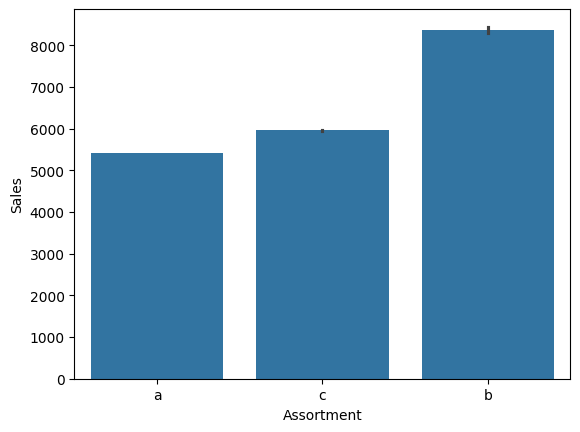

In [ ]:
sns.barplot(x='Assortment', y='Sales', data=Store_train_dataset)
plt.show()

**Converting Data Types**

In [ ]:
train_test_dataset = pd.concat([Train_Dataset,Test_Dataset],ignore_index=True)

In [ ]:
train_test_dataset

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day_Name,Weekends,Id
0,1,5,2015-07-31 00:00:00,5263.0,555.0,1.0,1,0,1,Friday,0.0,NaN
1,2,5,2015-07-31 00:00:00,6064.0,625.0,1.0,1,0,1,Friday,0.0,NaN
2,3,5,2015-07-31 00:00:00,8314.0,821.0,1.0,1,0,1,Friday,0.0,NaN
3,4,5,2015-07-31 00:00:00,13995.0,1485.0,1.0,1,0,1,Friday,0.0,NaN
4,5,5,2015-07-31 00:00:00,4822.0,559.0,1.0,1,0,1,Friday,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1058292,1111,6,2015-08-01,NaN,NaN,1.0,0,0,0,NaN,NaN,41084.0
1058293,1112,6,2015-08-01,NaN,NaN,1.0,0,0,0,NaN,NaN,41085.0
1058294,1113,6,2015-08-01,NaN,NaN,1.0,0,0,0,NaN,NaN,41086.0
1058295,1114,6,2015-08-01,NaN,NaN,1.0,0,0,0,NaN,NaN,41087.0


In [ ]:
train_test_dataset.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,41088
Customers,41088
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
Day_Name,41088


**Changing Datatypes**

In [40]:
Train_Dataset['Date'] = pd.to_datetime(Train_Dataset['Date'], format='%d-%m-%Y').astype('int64')

In [41]:
Test_Dataset['Date'] = pd.to_datetime(Test_Dataset['Date'], format='%Y-%m-%d').astype('int64')

In [ ]:
Test_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  int64  
 4   Open           41088 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 2.5+ MB


**. Machine Learning Models with Scikit-learn Pipelines**


In [42]:
X_train = Train_Dataset.drop(['Sales','Customers','Day_Name','Weekends'],axis=1)
y_train = Train_Dataset['Sales']
X_test = Test_Dataset.drop(['Id'],axis=1)


In [ ]:
X_train.shape,y_train.shape,X_test.shape

((1017209, 7), (1017209,), (41088, 7))

In [ ]:
X_train

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,1438300800000000000,1,1,0,1
1,2,5,1438300800000000000,1,1,0,1
2,3,5,1438300800000000000,1,1,0,1
3,4,5,1438300800000000000,1,1,0,1
4,5,5,1438300800000000000,1,1,0,1
...,...,...,...,...,...,...,...
1017204,1111,2,1356998400000000000,0,0,a,1
1017205,1112,2,1356998400000000000,0,0,a,1
1017206,1113,2,1356998400000000000,0,0,a,1
1017207,1114,2,1356998400000000000,0,0,a,1


**Encoding Categorical Varibles**

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  int64 
 3   Open           1017209 non-null  int64 
 4   Promo          1017209 non-null  int64 
 5   StateHoliday   1017209 non-null  object
 6   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 54.3+ MB


In [ ]:
X_train['StateHoliday'].value_counts()

,count
StateHoliday,
0,986159
a,20260
b,6690
c,4100


In [43]:
p1 = ColumnTransformer(transformers=[
    ('StateHoliday',OrdinalEncoder(categories=[['0','a','b','c']]),[5])
],remainder = 'passthrough')

In [11]:
oe = OrdinalEncoder(categories=[['0','a','b','c']],handle_unknown='use_encoded_value',unknown_value=np.nan)
X_train['StateHoliday']=oe.fit_transform(X_train[['StateHoliday']])

**Standerd Scaler**

In [44]:
p2 = ColumnTransformer(transformers=[
    ('ss',StandardScaler(),slice(0,7))
])

In [ ]:
#Standerd Scaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)

In [12]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import make_scorer,r2_score

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=45)
r2 = make_scorer(r2_score)
r2_scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring=r2)
score = r2_scores.mean()
print(score)

0.6029727198199947


In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = make_scorer(r2_score)
r2_scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring=r2)
score = r2_scores.mean()
print(score)

0.7167310217156813


In [13]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = make_scorer(r2_score)
r2_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=r2)
score = r2_scores.mean()
print(score)

0.7953117310376306


In [58]:
p4 = RandomForestRegressor()

**Applying Mathematical Transformations**

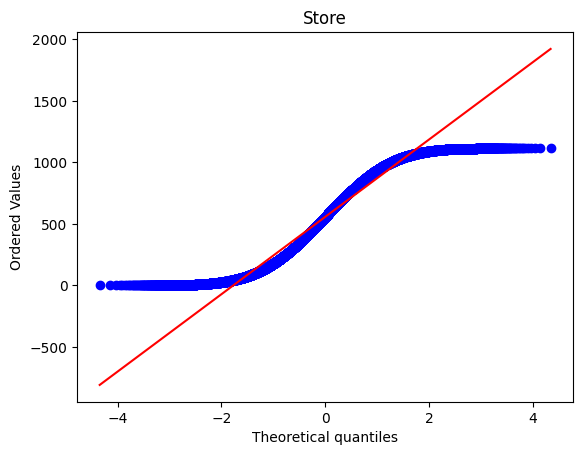

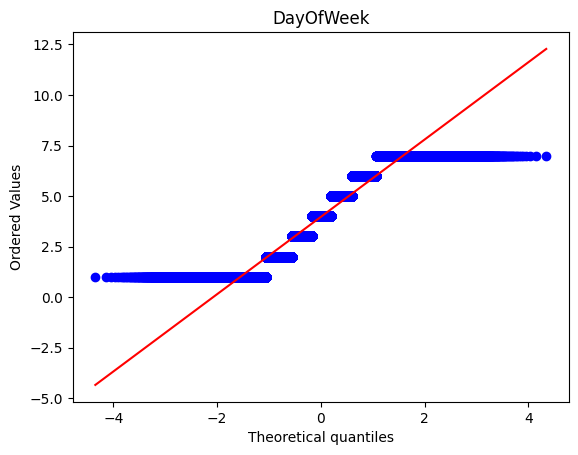

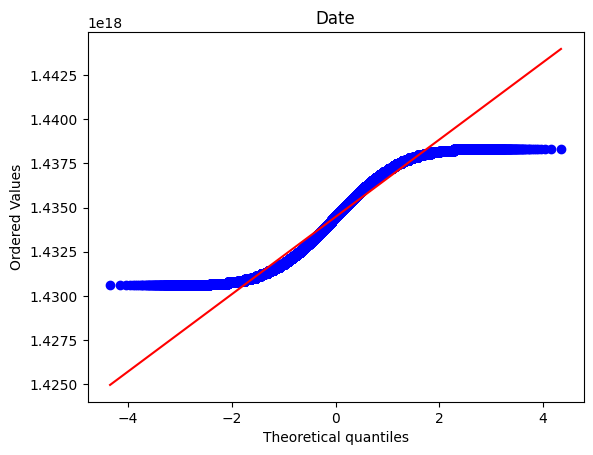

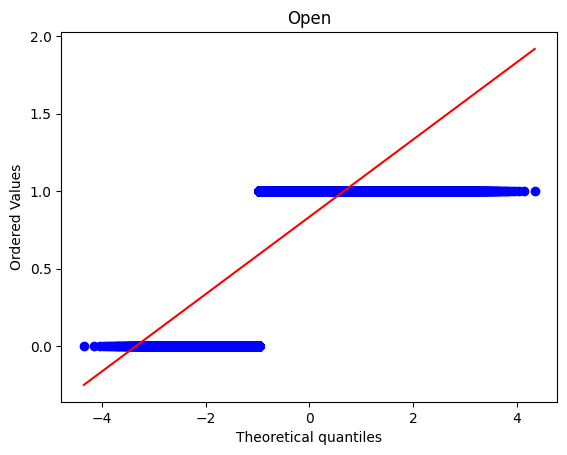

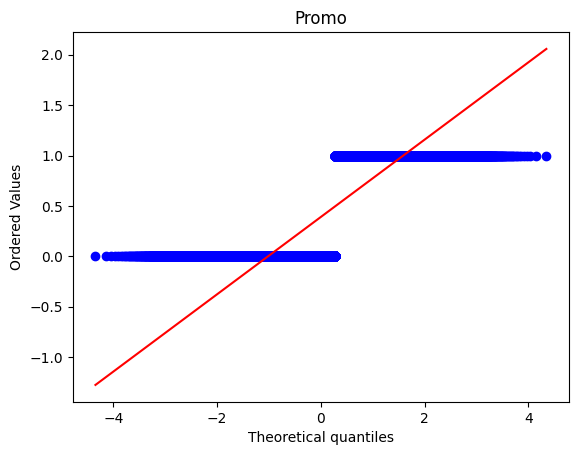

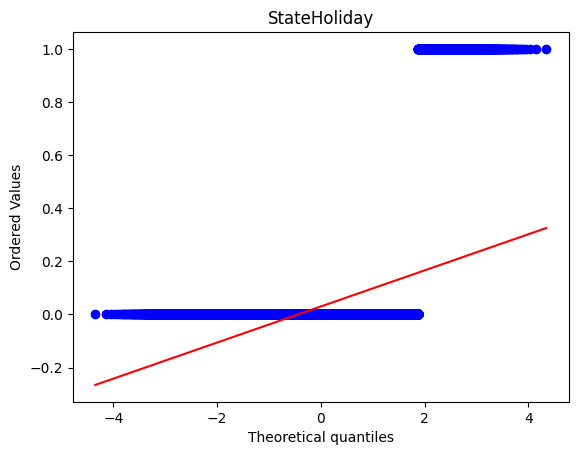

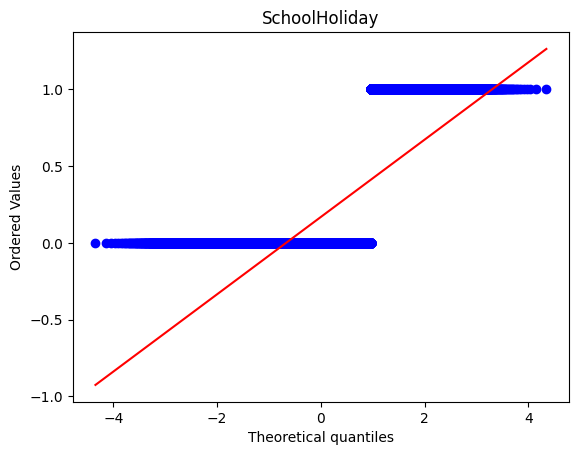

In [ ]:
for i in X_train.columns:

  stats.probplot(X_train[i], dist="norm", plot=plt)
  plt.title(i)
  plt.show()

In [ ]:
pt = PowerTransformer(method = 'yeo-johnson')
X_train = pt.fit_transform(X_train)

In [ ]:
#Standerd Scaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=45)
r2 = make_scorer(r2_score)
r2_scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring=r2)
score = r2_scores.mean()
print(score)

0.6107866673188347


In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = make_scorer(r2_score)
r2_scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring=r2)
score = r2_scores.mean()
print(score)

0.7344270161747083


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = make_scorer(r2_score)
r2_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=r2)
score = r2_scores.mean()
print(score)

0.8191888806506509


After Applying Mathematical transformation 1 % has been increased

In [59]:
p3 = PowerTransformer(method = 'yeo-johnson')

**Pipeline**

In [60]:
Pipe = Pipeline([
    ('p1',p1),
    ('p2',p2),
    ('p3',p3),
    ('p4',p4)
])

In [61]:
Pipe.fit(X_train,y_train)

Pipeline(steps=[('p1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StateHoliday',
                                                  OrdinalEncoder(categories=[['0',
                                                                              'a',
                                                                              'b',
                                                                              'c']]),
                                                  [5])])),
                ('p2',
                 ColumnTransformer(transformers=[('ss', StandardScaler(),
                                                  slice(0, 7, None))])),
                ('p3', PowerTransformer()), ('p4', RandomForestRegressor())])

In [54]:
y_pred = Pipe.predict(X_test)

In [55]:
y_pred

array([ 6702.28,  8016.96, 10672.53, ...,  5102.77, 14148.5 ,  9020.68])

In [62]:
cross_val_score(Pipe,X_train,y_train,cv=5,scoring='r2').mean()

0.8862008907777053

**Feature Importance**

In [51]:
p3.feature_importances_

array([2.27774003e-04, 3.39383944e-01, 2.27549916e-02, 3.12043879e-02,
       5.25009163e-01, 7.75941374e-02, 3.82560243e-03])

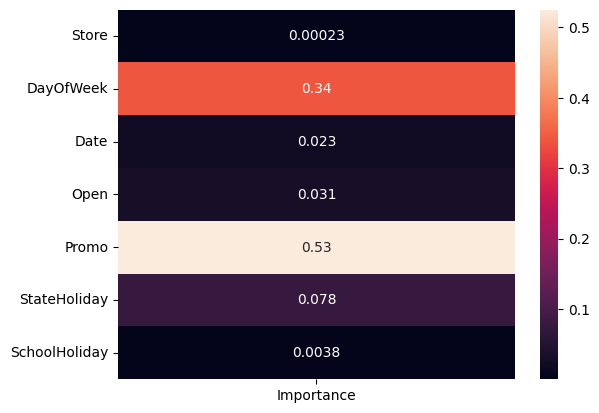

In [52]:
sns.heatmap(pd.DataFrame(p3.feature_importances_,index=X_train.columns,columns=['Importance']),annot=True)
plt.show()

From This we can Say that Promo Has High Importance than Others

**Model Serialization**

In [57]:
import pickle
pickle.dump(Pipe,open('/project-6.pkl','wb'))